# Accessing Temporal Profiles Corresponding to `reV` Supply Curve Outputs

One major advantage of reV supply curve outputs is that they come with temporal capactity factor profiles that can be used for downstream analysis.
In this quick guide, we will demonstrate how to take a supply curve CSV and extract the corresponing temporal profiles form the accompanying HDF5 file.

We will demonstrate how to do this using two methods: Using the custom `rex` library (recommended) or the `h5py` library.

NOTE: The column ncf_2035 includes a technology improvement associated with the moderate ATB technology scenario (https://atb.nrel.gov/electricity/2024/offshore_wind). In order to match values in the the HDF5 profile values, multiply by 1.056875 (with a ceiling on 1), to align with the values in the supply curve.

Let's start with a few common imports:

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Using [`rex`](https://github.com/NREL/rex/) (recommended)

We recommend using the `rex` (https://github.com/NREL/rex/) library to read temporal profiles. This library was used to write the reV data to file and makes interfacing with these HDF5 file seamless. 

Let's begin by reading in the supply curve CSV using `pandas`:

In [41]:
reference_osw_supply_curve = pd.read_csv("reference_supply-curve_post_proc.csv")
reference_osw_supply_curve.head()

latitude   longitude  sc_point_gid  sc_gid  resource  \
0  46.823877 -124.234819          5497      24  7.709999   
1  46.695565 -124.170291          5818      28  7.714195   
2  46.143137 -124.123451          7101      45  7.766990   
3  46.014858 -124.059918          7422      50  7.591774   
4  45.719174 -124.140603          8063      66  7.777247   

   area_developable_sq_km  capacity_ac_mw  mean_depth  mean_dist_p_to_s  \
0                  0.3483          1.3932   25.511627         34.038654   
1                  2.1627          8.6508   13.445693         44.166600   
2                  2.2599          9.0396   23.810036         16.998842   
3                 11.4129         45.6516   37.464870         21.979690   
4                  5.7672         23.0688   58.198032         55.766580   

   mean_wake_losses-means  ...  cost_reinforcement_usd_per_mw  \
0               10.919320  ...                    3496.287639   
1               11.091313  ...                    3496.287639   
2               11.865570  ...                   22651.756846   
3               10.984771  ...                   22651.756846   
4               14.446201  ...                   22651.756846   

   cost_total_trans_usd_per_mw  lcot_usd_per_mwh  offtake_state  \
0                    865450.44         19.338501             WA   
1                    847943.94         19.110750             WA   
2                    812141.94         18.433187             OR   
3                    683799.70         16.324333             OR   
4                    725080.40         16.480598             OR   

   cost_occ_2035_usd_per_mw  cost_opex_2035_usd_per_mw   ncf_2035  technology  \
0              4.842217e+06               74391.745700  38.189378       fixed   
1              4.560148e+06               74493.249174  37.862786       fixed   
2              4.791886e+06               74137.368343  37.597128       fixed   
3              5.060088e+06               74203.423037  35.745108       fixed   
4              5.553040e+06               73484.270068  37.543639       fixed   

   site_lcoe_usd_per_mwh_2035  all_in_lcoe_2035  
0                  133.254974        152.593475  
1                  127.912180        147.022930  
2                  134.104728        152.537915  
3                  147.643576        163.967909  
4                  151.848391        168.328989  

[5 rows x 27 columns]

As we can see, every row of the supply curve has a unique `sc_gid` value. This is what we will use to link with the temporal profiles. Let's begin by reading in the metadata from the rep-profiles HDF5 file using the `Resource` class in `rex`:

In [42]:
from rex import Resource

with Resource("reference_rep-profiles_2012.h5") as res:
    print(res.shapes)

print("Supply curve length:", len(reference_osw_supply_curve))

{'meta': (4223,), 'rep_profiles_0': (8760, 4223), 'time_index': (8760,)}
Supply curve length: 4223


As we can see, the HDF5 file contains the profiles in the "rep_profiles_0" dataset. Also, the length of the supply curve matches the spatial shape (second index) of the temporal profiles. This makes it easy to extract the profile for the point of interest: simply find the `sc_gid` of the supply curve point you are interested in and extract the profile using `sc_gid` as the index. 


### Extracting info by SC point GID

If you already know what sc point gid(s) you want to examine, extraction is straightforward:

In [43]:
# Determine what gid to examine using the "reference_osw_supply_curve"
sc_point_gid_of_interest = 14652
ind = reference_osw_supply_curve[
    reference_osw_supply_curve["sc_point_gid"] == sc_point_gid_of_interest
]["sc_gid"]

with Resource("reference_rep-profiles_2012.h5") as res:
    profile = (1.056875 * res["rep_profiles_0", :, ind]).clip(max=1) #this is the 2035 values with technology improvements
    ti = res.time_index

profile.shape

(8760, 1)

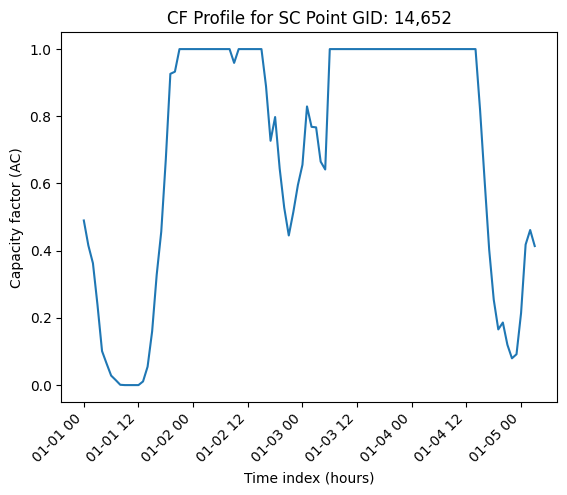

In [44]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: {sc_point_gid_of_interest:,}")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");

You can also extract multiple profiles at the same time:

In [45]:
sc_point_gids_of_interest = [14652, 22064, 46158]
points = reference_osw_supply_curve[
    reference_osw_supply_curve["sc_point_gid"].isin(
        sc_point_gids_of_interest
    )
]
inds = points["sc_gid"]

with Resource("reference_rep-profiles_2012.h5") as res:
    profiles = (1.056875 * res["rep_profiles_0", :, inds]).clip(max=1) #this is the 2035 values with technology improvements
    ti = res.time_index

profiles.shape

(8760, 3)

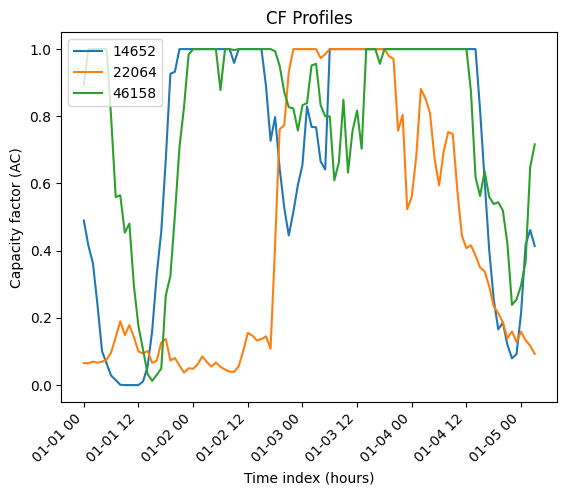

In [46]:
plt.plot(ti[:100], profiles[:100], label=points["sc_point_gid"])
plt.title(f"CF Profiles")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper left");

### Extracting info by Lat/Lon

Often you have a location you'd like to examine in particular. You know the lat/lon but don't know which SC point GID they belong to. In this case, you can use `rex.ResourceX` to look up the `sc_gid`!

In [47]:
from rex import ResourceX

with ResourceX("reference_rep-profiles_2012.h5") as res:
    sc_gid = res.lat_lon_gid((29.84725221, -88.52928113))

sc_gid

847

You can then extract the supply curve information:

In [48]:
point = reference_osw_supply_curve[
    reference_osw_supply_curve["sc_gid"] == sc_gid
]
point[[
    "sc_gid", "latitude", "longitude", "capacity_ac_mw", "area_developable_sq_km", "ncf_2035",
    "lcot_usd_per_mwh", "all_in_lcoe_2035"
]]

sc_gid   latitude  longitude  capacity_ac_mw  area_developable_sq_km  \
2083     847  43.550039 -77.793829       1003.6224                250.9056   

      ncf_2035  lcot_usd_per_mwh  all_in_lcoe_2035  
2083  45.36545         57.415287        162.726383

and the profile information just like before!

In [49]:
with Resource("reference_rep-profiles_2012.h5") as res:
    profile = (1.056875 * res["rep_profiles_0", :, sc_gid]).clip(max=1) #this is the 2035 values with technology improvements

    ti = res.time_index

profile.shape

(8760,)

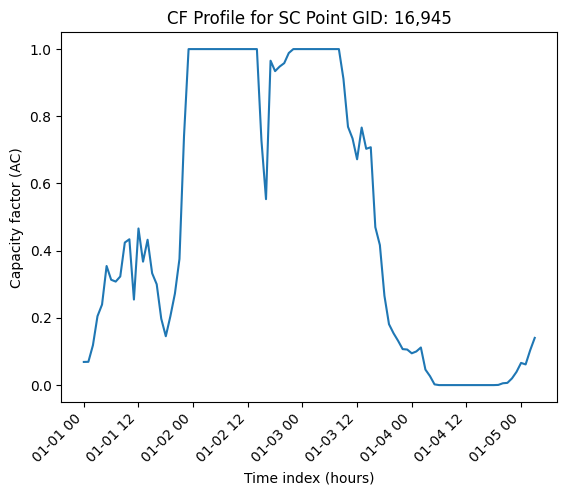

In [50]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: {point['sc_point_gid'].iloc[0]:,}")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");

# Using `h5py`

You can also use the standard `h5py` library to read the temporal profiles.
The access pattern remains largely the same, except that you have to perform more processing as you load in the data.

Let's begin the example once agin by reading in the supply curve CSV using `pandas`:

In [51]:
reference_osw_supply_curve = pd.read_csv("reference_supply-curve_post_proc.csv")
reference_osw_supply_curve.head()

latitude   longitude  sc_point_gid  sc_gid  resource  \
0  46.823877 -124.234819          5497      24  7.709999   
1  46.695565 -124.170291          5818      28  7.714195   
2  46.143137 -124.123451          7101      45  7.766990   
3  46.014858 -124.059918          7422      50  7.591774   
4  45.719174 -124.140603          8063      66  7.777247   

   area_developable_sq_km  capacity_ac_mw  mean_depth  mean_dist_p_to_s  \
0                  0.3483          1.3932   25.511627         34.038654   
1                  2.1627          8.6508   13.445693         44.166600   
2                  2.2599          9.0396   23.810036         16.998842   
3                 11.4129         45.6516   37.464870         21.979690   
4                  5.7672         23.0688   58.198032         55.766580   

   mean_wake_losses-means  ...  cost_reinforcement_usd_per_mw  \
0               10.919320  ...                    3496.287639   
1               11.091313  ...                    3496.287639   
2               11.865570  ...                   22651.756846   
3               10.984771  ...                   22651.756846   
4               14.446201  ...                   22651.756846   

   cost_total_trans_usd_per_mw  lcot_usd_per_mwh  offtake_state  \
0                    865450.44         19.338501             WA   
1                    847943.94         19.110750             WA   
2                    812141.94         18.433187             OR   
3                    683799.70         16.324333             OR   
4                    725080.40         16.480598             OR   

   cost_occ_2035_usd_per_mw  cost_opex_2035_usd_per_mw   ncf_2035  technology  \
0              4.842217e+06               74391.745700  38.189378       fixed   
1              4.560148e+06               74493.249174  37.862786       fixed   
2              4.791886e+06               74137.368343  37.597128       fixed   
3              5.060088e+06               74203.423037  35.745108       fixed   
4              5.553040e+06               73484.270068  37.543639       fixed   

   site_lcoe_usd_per_mwh_2035  all_in_lcoe_2035  
0                  133.254974        152.593475  
1                  127.912180        147.022930  
2                  134.104728        152.537915  
3                  147.643576        163.967909  
4                  151.848391        168.328989  

[5 rows x 27 columns]

### Extracting info by SC point GID

As before, extraction is fairly straightforward if we know the `sc_point_gid` we are interested in:

In [52]:
reference_osw_supply_curve[
    reference_osw_supply_curve["sc_point_gid"] == 14652
]

latitude  longitude  sc_point_gid  sc_gid  resource  \
68  45.35528 -87.226323         14652     572  8.465547   

    area_developable_sq_km  capacity_ac_mw  mean_depth  mean_dist_p_to_s  \
68                210.9645         843.858   27.974966         28.128904   

    mean_wake_losses-means  ...  cost_reinforcement_usd_per_mw  \
68               10.121917  ...                    5493.639472   

    cost_total_trans_usd_per_mw  lcot_usd_per_mwh  offtake_state  \
68                    604433.94         11.127889             WI   

    cost_occ_2035_usd_per_mw  cost_opex_2035_usd_per_mw   ncf_2035  \
68              2.802442e+06               74079.548975  46.351013   

    technology  site_lcoe_usd_per_mwh_2035  all_in_lcoe_2035  
68       fixed                   71.182757         82.310646  

[1 rows x 27 columns]

When we go to read the HDF5 file, we first have to look through all the datasets and shapes contained within:

In [53]:
import h5py

with h5py.File("reference_rep-profiles_2012.h5", "r") as fh:
    for dset in fh.keys():
        print(f"{dset}: {fh[dset].shape}")

meta: (4223,)
rep_profiles_0: (8760, 4223)
time_index: (8760,)


The wind bespoke output files have a lot more datasets than standard reV files. Still, we see that the datasets of interest for us are "cf_profile-\<year\>". 
Let's extract the correct one now, along with the time index. Note the extra steps we have to take to scale the profiles appropriately and get the time index converted into a `pandas.DateTimeIndex`.
The custom `rex` library perfoms all of this processing under the hood and therefore drastically reduces the complexity of I/O.

In [54]:
ind = reference_osw_supply_curve[
    reference_osw_supply_curve["sc_point_gid"] == 14652
]["sc_gid"]

with h5py.File("reference_rep-profiles_2012.h5", "r") as fh:
    profile = (1.056875 * fh["rep_profiles_0"][:, ind]).clip(max=1) #this is the 2035 values with technology improvements
    ti = pd.to_datetime(fh["time_index"][:].astype(str))

profile.shape

(8760, 1)

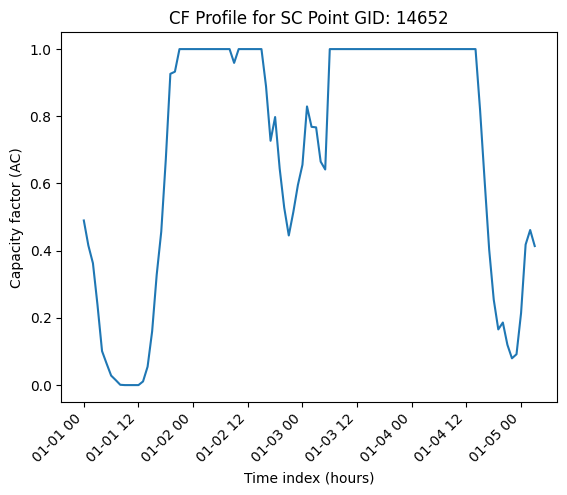

In [55]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: 14652")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");

Reading in multiple profiles at once can be done as well:

In [56]:
sc_point_gids_of_interest = [14652, 22064, 46158]
points = reference_osw_supply_curve[
    reference_osw_supply_curve["sc_point_gid"].isin(sc_point_gids_of_interest)
]
inds = points["sc_gid"]

with h5py.File("reference_rep-profiles_2012.h5", "r") as fh:
    profiles = (1.056875 * fh["rep_profiles_0"][:, inds]).clip(max=1) #this is the 2035 values with technology improvements
    ti = pd.to_datetime(fh["time_index"][:].astype(str))

profiles.shape

(8760, 3)

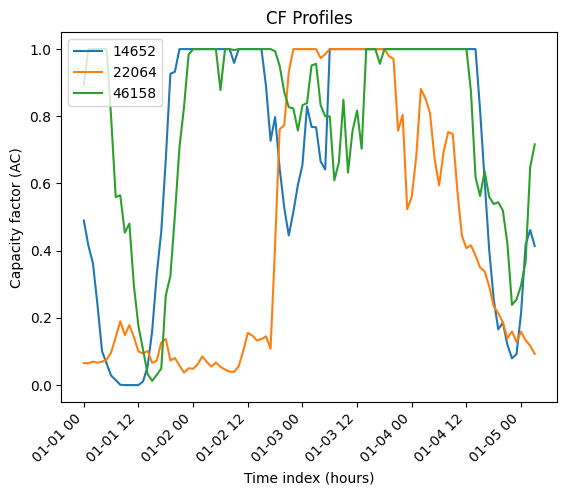

In [57]:
plt.plot(ti[:100], profiles[:100], label=points["sc_point_gid"])
plt.title(f"CF Profiles")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper left");

### Extracting info by Lat/Lon

Extracting info for a particular lat/lon is trickier without `rex`, but still doable. You have a few options - the simplest is to do a supply curve sort by a distance to your desired lat/lon (this is what we show below). A more sophisticated but likely more accurate approach is to use a [`cKDtree`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html) to look up the closest lat/lon pair to the point in question. This approach is not covered in this notebook.

In [58]:
import numpy as np

my_lat, my_lon = 48.346832, -124.6527

reference_osw_supply_curve["dist_to_my_point"] = np.hypot(
    reference_osw_supply_curve["latitude"] - my_lat,
    reference_osw_supply_curve["longitude"] - my_lon
)
point = reference_osw_supply_curve.sort_values(
    by="dist_to_my_point"
).iloc[[0]]
point

latitude   longitude  sc_point_gid  sc_gid  resource  \
1486  48.322352 -125.247842          1644       4  7.969067   

      area_developable_sq_km  capacity_ac_mw  mean_depth  mean_dist_p_to_s  \
1486                  0.6075            2.43      114.84         191.84766   

      mean_wake_losses-means  ...  cost_total_trans_usd_per_mw  \
1486               10.168231  ...                    2157469.0   

      lcot_usd_per_mwh  offtake_state  cost_occ_2035_usd_per_mw  \
1486          45.83546             WA              8.365851e+06   

      cost_opex_2035_usd_per_mw   ncf_2035  technology  \
1486               66543.889525  40.166698    floating   

      site_lcoe_usd_per_mwh_2035  all_in_lcoe_2035  dist_to_my_point  
1486                  201.274434        247.109894          0.595645  

[1 rows x 28 columns]

Once you know the `sc_gid`, you can proceed as before:

In [59]:
with h5py.File("reference_rep-profiles_2012.h5", "r") as fh:
    profile = (1.056875 * fh["rep_profiles_0"][:, point["sc_gid"]]).clip(max=1) #this is the 2035 values with technology improvements

    ti = pd.to_datetime(fh["time_index"][:].astype(str))

profile.shape

(8760, 1)

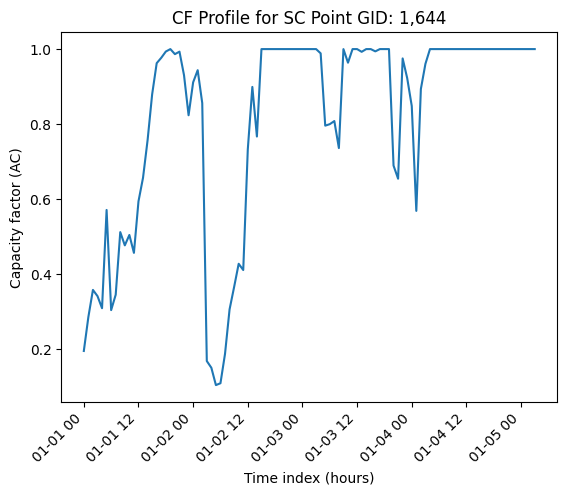

In [60]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: {point['sc_point_gid'].iloc[0]:,}")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");